In [ ]:
'''やること
異常値検出のメジャーなアルゴリズムである「OneClassSVM」をやってみよう
sklearnのハンズオンをそのままコピペっている。
http://scikit-learn.org/stable/auto_examples/svm/plot_oneclass.html#sphx-glr-auto-examples-svm-plot-oneclass-py

・参考にしたURL(というより、下記の説明はほとんどコピペ)
https://qiita.com/kznx/items/434d98bf1a0e39327542
'''


'''アルゴリズムの概要
①SVM を利用した外れ値検知手法。
②カーネルを使って特徴空間に写像、元空間上で孤立した点は特徴空間では原点付近に分布する。
（なぜそのような結果になるのか、については下記の「アルゴリズムの詳細についてのメモ」の⑤を参照。
③識別超平面よりも原点側にあるデータが異常、という判断をする
④識別超平面を挟んで特徴空間上の原点との反対側にあるデータを多くしつつ、超平面と原点のマージンを大きくするように計算する
⑤次元の呪いには気をつけて（距離を計算するので、次元の呪い対策が必須）
⑥SVMは本来教師あり学習だが、OneClassSVMは教師なし学習です。
'''


'''ユーザーが指定するハイパーパラメータ
下記の2つ。
σ : カーネルにRBF(radial basis function)を用いているため。
　　　　　値が小さいほど単純な決定境界となり, 大きいほど複雑な決定境界となります。
ν : １クラスサポートベクターマシンはνサポートベクターマシンにもとづいています。νによりデータに占める外れ値の割合の上限を指定できます。
　　　　（どれだけ誤差を許容するか）
    大きいほど汎化性能が高まり、過学習を起こしにくい。
    ３シグマ法にもとづいて考えると、ν=0.003になります。
'''


'''流れ
1.sklearnのチュートリアルを参考に一回動かしてみる
2.教師あり学習でもやってみる。
ハイパーパラメータをgridsearchで調節する
'''


'''参考
・PFIの比戸さんの資料
https://research.preferred.jp/2013/01/outlier/

・筑波大学の学生の修士論文
https://www.sk.tsukuba.ac.jp/SSE/degree/2007/thesis/200620812.pdf

・誰かのブログ（OneClassSVMにおける処理の流れをわかりやすく、まとめている）
http://univprof.com/archives/16-06-03-3678374.html
'''


'''アルゴリズムの詳細についてのメモ
①識別超平面を求める際の計算内容
多くの訓練パターンが判別超平面を挟んで特徴空間上の原点との反対側にあることを維持しながら超平面と原点のマージンを大きくすることで高密度領域の推定を目指す．
②Kernelはデフォルトのrbfで、だいたいOKでしょ。
③異常データの割合を決めるnu(0~1の範囲、def.= 0.5)を変更してみると結果が変わるので面白い。
④（1-ρ）割のサンプルを最小の体積に押し込めるような識別超平面を作る。
⑤適切なカーネル関数を設計することで、様々なデータに対応可能
'''

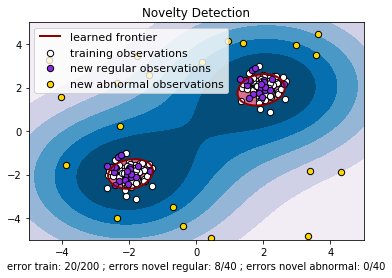

In [6]:
# -*- coding: utf-8 -*-
% matplotlib inline


'''sklearnのチュートリアルのコピペ
2次元のサンプルデータを乱数で生成して、トレーニング用、テスト用、外れ値用の３種類データを生成している。
'''

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500)) # 最終結果を表示するために利用
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-5, high=5, size=(20, 2)) # -5~5の乱数を20行２列で生成

# fit the model
clf = svm.OneClassSVM(nu=0.1, 
                      kernel="rbf", 
                      gamma=0.1
                     )
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size # 外れ値とみなされたデータポイントは-1が入るので、その個数を求めている。
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s,
                edgecolors='k')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()

In [ ]:
'''業務に利用するために...
①次元の呪いに対抗するための前処理を追加
（PCA,特異値分解あたり）
'''

上記はそれぞれのアルゴリズム利用コードをそのまま利用することを想定するので一旦保留。